In [1]:
import numpy as np
import scipy.integrate as integrate
from scipy.special import hyp2f1
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Indices of variables in the state.
iqc = 0
iqr = 1

accr_power = 1.15

def accretion_rate(t, state):
    """Rate of accretion based on a non-dimensionalized version of MG2's power law formula."""
    output = np.zeros((2,))
    mass_tend = (state[iqc] * state[iqr])**accr_power
    output[iqc] = - mass_tend
    output[iqr] = mass_tend
    return output

/home/santos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


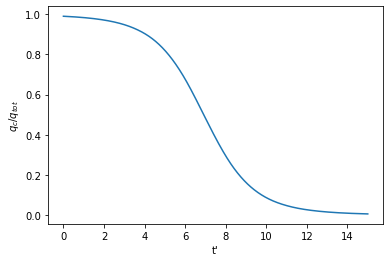

In [3]:
# Use SciPy's Runge-Kutta method to get an accurate solution.
state0 = np.zeros((2,))
state0[iqc] = 0.99
state0[iqr] = 0.01

t_span = (0., 15.)
num_steps = 1000
t_eval = np.linspace(t_span[0], t_span[1], num_steps+1)
accr_sol = integrate.solve_ivp(accretion_rate, t_span, state0, t_eval=t_eval)
sol_state = accr_sol.y

plt.plot(t_eval, sol_state[iqc,:])
plt.xlabel("t'")
plt.ylabel(r'$q_c / q_{tot}$')
plt.savefig('accretion_qc.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


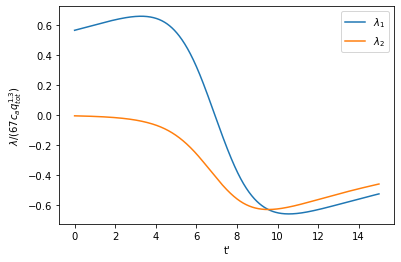

In [4]:
def calc_lambda(qc, qr):
    return accr_power * (qc - qr) * (qc * qr)**(accr_power-1)

def calc_lambda2(qc, qr):
    return -(qc * qr)**accr_power / qc

lambdas = calc_lambda(sol_state[iqc,:], sol_state[iqr,:])
lambdas2 = calc_lambda2(sol_state[iqc,:], sol_state[iqr,:])

plt.plot(t_eval, lambdas, label=r'$\lambda_1$')
plt.plot(t_eval, lambdas2, label=r'$\lambda_2$')
plt.xlabel("t'")
plt.ylabel(r'$\lambda / (67 c_a q_{tot}^{1.3})$')
plt.legend()
plt.savefig('accretion_lambdas.eps')

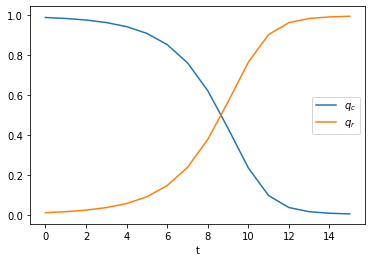

In [5]:
def euler_integrate(f, t_span, state0, t_eval):
    """Initial value problem solver with forward Euler method.
    
    Arguments correspond to their solve_ivp equivalents, except
    that t_eval governs the time steps used, as well as the
    return values.
    """
    nsteps = len(t_eval) - 1
    output = np.zeros((len(state0), nsteps+1))
    output[:,0] = state0
    for i in range(nsteps):
        deltat = t_eval[i+1] - t_eval[i]
        output[:,i+1] = output[:,i] + accretion_rate(t_eval[i], output[:,i])* deltat
    return output

nsteps = 15
t_eval = np.linspace(t_span[0], t_span[1], nsteps+1)
euler_state = euler_integrate(accretion_rate, t_span, state0, t_eval)

plt.plot(t_eval, euler_state[iqc,:], label=r'$q_c$')
plt.plot(t_eval, euler_state[iqr,:], label=r'$q_r$')
plt.xlabel('t')
plt.legend()

Text(0, 0.5, '$\\lambda$')

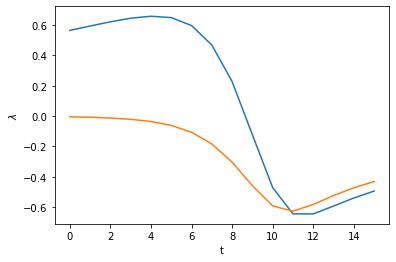

In [6]:
lambdas = calc_lambda(euler_state[iqc,:], euler_state[iqr,:])
lambdas2 = calc_lambda2(euler_state[iqc,:], euler_state[iqr,:])

plt.plot(t_eval, lambdas)
plt.plot(t_eval, lambdas2)
plt.xlabel('t')
plt.ylabel(r'$\lambda$')

In [7]:
def half_time(q_tot, qc0):
    """Time when half the total cloud water is cloud, and half rain.

    Derived from an analytic solution to the accretion equation.
    q_tot is total water, and qc0 is the cloud water at t = 0.
    """
    rat0 = (2*qc0 / q_tot) - 1 # Ratio of water removed to q_tot / 2.
    return (q_tot / 2.)**(1 - 2*accr_power) * rat0 * hyp2f1(0.5, accr_power, 1.5, rat0*rat0)

q_tot = state0[iqc] + state0[iqr]
exact_half_time = half_time(q_tot, state0[iqc])
print(exact_half_time)

6.9183418860154


1.855826344550948


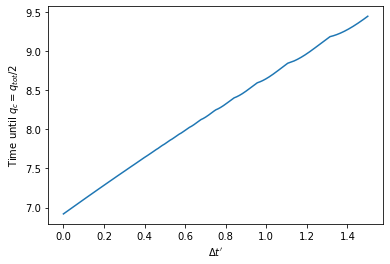

In [8]:
def euler_half_time(q_tot, qc0, deltat):
    """Time when half the total cloud water is cloud using the forward Euler method.

    q_tot is total water, qc0 is the cloud water at t = 0, and deltat is the model time step.
    """
    if qc0 < q_tot / 2.:
        return 0.
    # Single steps for Euler method.
    t_span = (0., deltat)
    state = np.zeros((2,))
    state[iqc] = qc0
    state[iqr] = q_tot - qc0
    qc = qc0
    t = 0.
    while qc > q_tot / 2.:
        t += deltat
        states = euler_integrate(accretion_rate, t_span, state, t_span)
        state = states[:,1]
        qc = states[iqc,1]
    return t - (states[iqc,1] - (q_tot / 2.)) * deltat / (states[iqc,1] - states[iqc,0])

n_deltas = 1000
deltats = np.linspace(0., 1.5, n_deltas+1)
euler_times = np.zeros((n_deltas+1,))
euler_times[0] = exact_half_time

for i in range(n_deltas):
    euler_times[i+1] = euler_half_time(q_tot, state0[iqc], deltats[i+1])

plt.plot(deltats, euler_times)
small_time_slope = (euler_times[3] - euler_times[1]) / (deltats[3] - deltats[1])
print(small_time_slope)
#plt.plot(deltats, exact_half_time + (small_time_slope*deltats), 'k--')
plt.xlabel(r"$\Delta t'$")
plt.ylabel("Time until $q_c = q_{tot}/2$")
plt.savefig("accretion_half_time.eps")

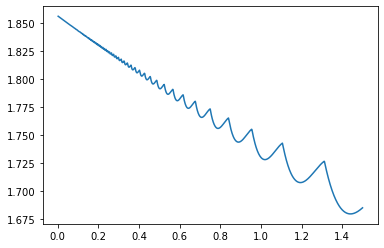

In [9]:
# Find out approximately how many time steps the cloud-halving time is delayed.
# Mostly to see whether "delayed by 1.8 time steps" is a good rule of thumb.
plt.plot(deltats[1:], (euler_times[1:] - euler_times[0]) / deltats[1:])

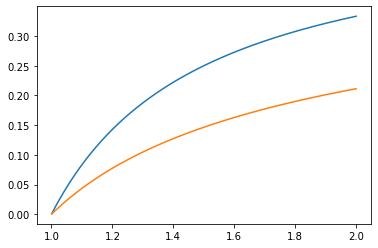

In [10]:
# Check value of q_c that requires the shortest time step for stability according
# to (a) requiring q_c > 0 for the forward Euler method, (b) absolute stability using
# \lambda_1 as the most negative eigenvalue.
#
# Here we are generalizing the power rule to 0 < p <= 2, instead of just p = 1.15.
ps = np.linspace(1.001, 2., 1001)
eul_maxes = (ps - 1) / (2*ps - 1)
lam_maxes = (1 - np.sqrt(1 / (2*ps - 1))) / 2

plt.plot(ps, eul_maxes)
plt.plot(ps, lam_maxes)

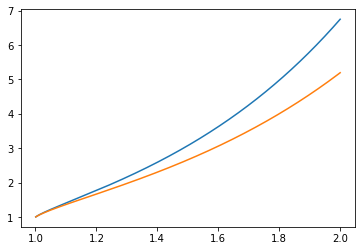

In [11]:
# The minimum time step needed to keep q_c > 0 with the forward Euler method.
eul_ts = ((ps - 1) / (2*ps - 1)) ** (1 - 2*ps) * ((ps - 1) / ps) ** ps
# The minimum value of 1 / \lambda_1.
lam_ts = np.sqrt(((ps - 1) / (2*(2*ps - 1))) ** (1 - 2*ps) * (ps-1) / (2*ps*ps))

plt.plot(ps, eul_ts)
plt.plot(ps, lam_ts)

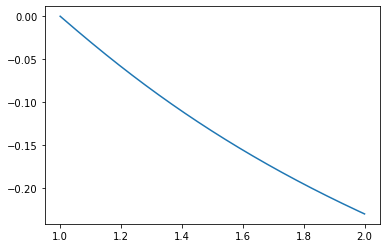

In [12]:
# Relative error in using \lambda_1 to estimate the time step needed for stability.
plt.plot(ps, (lam_ts - eul_ts) / eul_ts)

In [13]:
# Maximum time step guaranteed stable for forward Euler method @ p=1.15:
np.sqrt(((1.15 - 1) / (2*(2*1.15 - 1))) ** (1 - 2*1.15) * (1.15-1) / (2*1.15*1.15))

1.5209192234600766